In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [29]:
housing = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [30]:
# Check for missing values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [31]:
# check for distribution and measure of central tendacies
housing.describe(percentiles=[0.1,0.25,0.5,0.75,0.8,0.85,0.9,0.95,0.99])

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
10%,2.835000e+06,3000.000000,2.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
80%,6.093500e+06,6600.000000,3.000000,2.000000,2.000000,2.000000
85%,6.615000e+06,7157.000000,4.000000,2.000000,2.000000,2.000000


In [32]:
# dummy variables
labels = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea'] 
housing[labels] = housing[labels].apply(lambda x: x.map({'yes': 1, 'no':0}))

In [33]:
# dummy encoding for more than 2 labels for a categorical value
furnishing_status = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
housing = pd.concat((housing, furnishing_status), axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [34]:
# dropping furnishingstatus column
housing.drop(columns='furnishingstatus', inplace=True)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


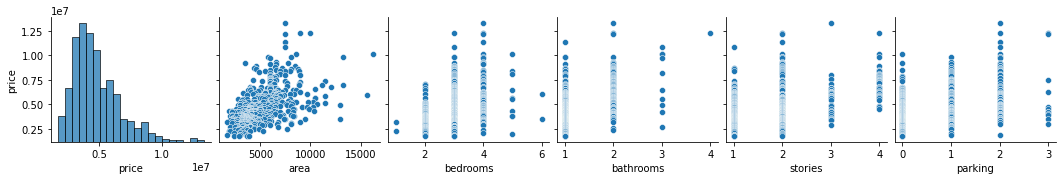

In [35]:
# pairplot of numerical columns
sns.pairplot(y_vars=['price'], x_vars=housing.columns.drop(labels).drop(['unfurnished', 'semi-furnished']), data=housing)
plt.show()

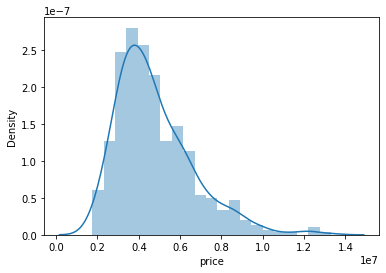

In [36]:
sns.distplot(housing.price)
plt.show()

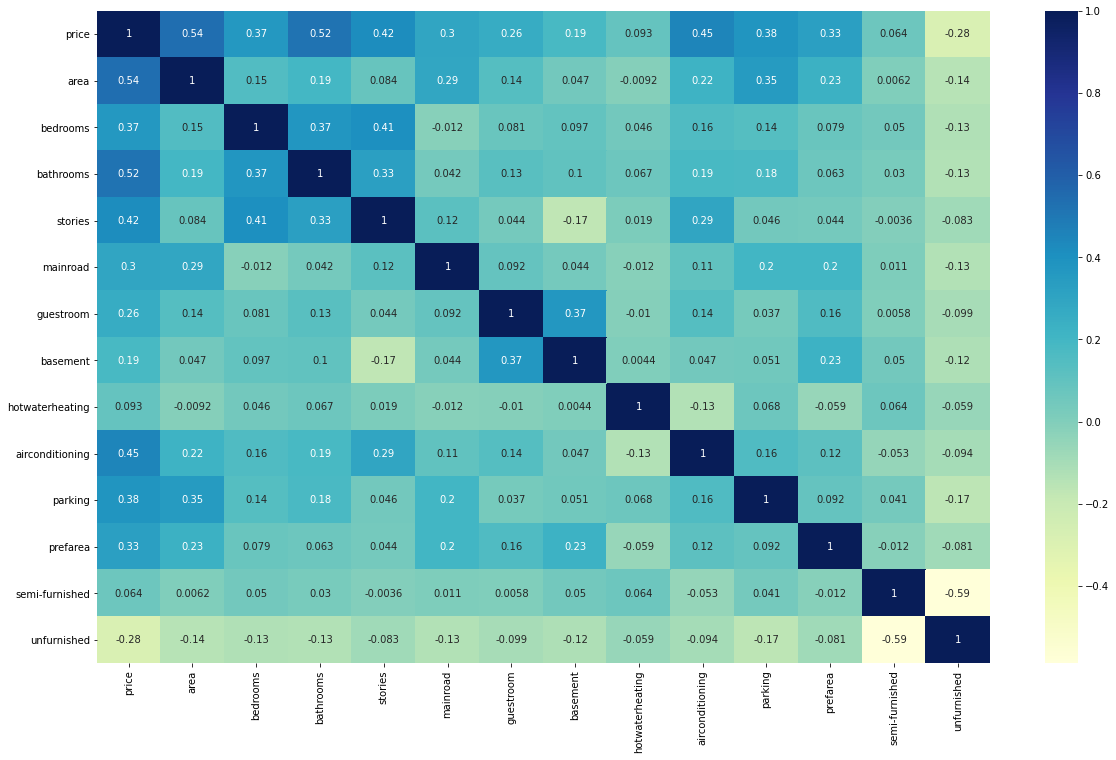

In [37]:
# heat map
plt.figure(figsize=(20,12))
sns.heatmap(housing.corr(), cmap='YlGnBu', annot=True)
plt.show()

<function matplotlib.pyplot.show>

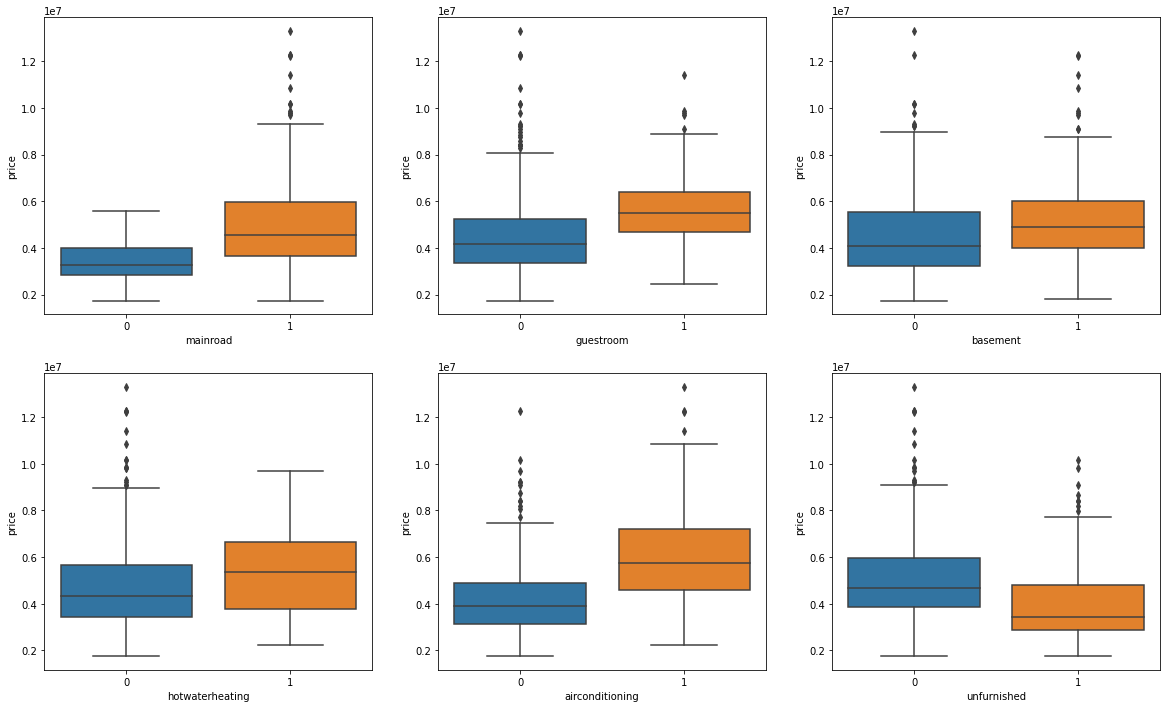

In [40]:
# categorical variable analysis
plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)
sns.boxplot(x='mainroad', y='price', data=housing)
plt.subplot(2, 3, 2)
sns.boxplot(x='guestroom', y='price', data=housing)
plt.subplot(2, 3, 3)
sns.boxplot(x='basement', y='price', data=housing)
plt.subplot(2, 3, 4)
sns.boxplot(x='hotwaterheating', y='price', data=housing)
plt.subplot(2, 3, 5)
sns.boxplot(x='airconditioning', y='price', data=housing)
plt.subplot(2, 3, 6)
sns.boxplot(x='unfurnished', y='price', data=housing)
plt.show

We can clealy see area bedrooms stories airconditioning parking and prefarea has some sort of correlation with the price of the house.

In [48]:
# split data
housing_train, housing_test = train_test_split(housing, train_size=0.7, shuffle=True, random_state=100)
print(housing_train.shape)
print(housing_test.shape)

(381, 14)
(164, 14)


In [49]:
# feature scaling
scalar = MinMaxScaler()
scalar.fit(housing_train)
numerical = ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'area']
housing_train[numerical] = scalar.fit_transform(housing_train[numerical])

In [50]:
housing_train.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.260333,0.288710,0.386352,0.136483,0.268591,0.855643,0.170604,0.351706,0.052493,0.299213,0.242345,0.233596,0.414698,0.325459
std,0.157607,0.181420,0.147336,0.237325,0.295001,0.351913,0.376657,0.478131,0.223313,0.458515,0.285933,0.423674,0.493318,0.469162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151515,0.155227,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.221212,0.234424,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.345455,0.398099,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
y_train = housing_train.pop('price')
X_train = housing_train

In [55]:
def vif_series(training_series):
  return pd.Series(data=[round(variance_inflation_factor(training_series.values, i), 2) for i in range(training_series.shape[1])], index=training_series.columns).sort_values(ascending=False)

vif_series(X_train)

bedrooms           7.33
mainroad           6.02
area               4.67
stories            2.70
semi-furnished     2.19
parking            2.12
basement           2.02
unfurnished        1.82
airconditioning    1.77
bathrooms          1.67
prefarea           1.51
guestroom          1.47
hotwaterheating    1.14
dtype: float64

In [60]:
# lets create model with all predictors
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           8.83e-83
Time:                        16:57:28   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021      0.955      0.340      -0.021       0.061
area                0.2347      0.030      7.795      0.000       0.175       0.294
bedrooms            0.0467      0.037      1.267      0.206      -0.026       0.119
bathrooms           0.1908      0.022      8.679      0.000       0.148       0.234
stories             0.1085      0.019      5.661      0.000       0.071       0.146
mainroad            0.0504      0.014      3.520      0.000       0.022       0.079
guestroom           0.0304      0.014      2.233      0.026       0.004       0.057
basement            0.0216      0.011      1.943      0.053      -0.000       0.043
hotwaterheating     0.0849      0.022      3.934      0.000       0.042       0.127
airconditioning     0.0669      0.011      5.899      0.000       0.045       0.089
parking             0.0607      0.018      3.365      0.001       0.025       0.096
prefarea            0.0594      0.012      5.040      0.000       0.036       0.083
semi-furnished      0.0009      0.012      0.078      0.938      -0.022       0.024
unfurnished        -0.0310      0.013     -2.440      0.015      -0.056      -0.006
==============================================================================
Omnibus:                       93.687   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.917
Skew:                           1.091   Prob(JB):                     6.14e-67
Kurtosis:                       6.801   Cond. No.                         14.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# semi-furnished has high p value. lets drop
columns = X_train.columns.drop('semi-furnished')
X_train_sm = sm.add_constant(X_train[columns])
lr = sm.OLS(y_train, X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           1.07e-83
Time:                        17:05:16   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019      1.098      0.273      -0.016       0.058
area                0.2344      0.030      7.845      0.000       0.176       0.293
bedrooms            0.0467      0.037      1.268      0.206      -0.026       0.119
bathrooms           0.1909      0.022      8.697      0.000       0.148       0.234
stories             0.1085      0.019      5.669      0.000       0.071       0.146
mainroad            0.0504      0.014      3.524      0.000       0.022       0.079
guestroom           0.0304      0.014      2.238      0.026       0.004       0.057
basement            0.0216      0.011      1.946      0.052      -0.000       0.043
hotwaterheating     0.0849      0.022      3.941      0.000       0.043       0.127
airconditioning     0.0668      0.011      5.923      0.000       0.045       0.089
parking             0.0608      0.018      3.372      0.001       0.025       0.096
prefarea            0.0594      0.012      5.046      0.000       0.036       0.083
unfurnished        -0.0316      0.010     -3.096      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       93.538   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.844
Skew:                           1.090   Prob(JB):                     1.05e-66
Kurtosis:                       6.794   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
vif_series(X_train[columns])

bedrooms           6.59
mainroad           5.68
area               4.67
stories            2.69
parking            2.12
basement           2.01
airconditioning    1.77
bathrooms          1.67
prefarea           1.51
guestroom          1.47
unfurnished        1.40
hotwaterheating    1.14
dtype: float64

In [73]:
# bedrooms has high p value and vif. lets drop
columns = columns.drop('bedrooms')
X_train_sm = sm.add_constant(X_train[columns])
lr = sm.OLS(y_train, X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           2.73e-84
Time:                        17:06:10   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015      2.421      0.016       0.007       0.065
area                0.2347      0.030      7.851      0.000       0.176       0.294
bathrooms           0.1965      0.022      9.132      0.000       0.154       0.239
stories             0.1178      0.018      6.654      0.000       0.083       0.153
mainroad            0.0488      0.014      3.423      0.001       0.021       0.077
guestroom           0.0301      0.014      2.211      0.028       0.003       0.057
basement            0.0239      0.011      2.183      0.030       0.002       0.045
hotwaterheating     0.0864      0.022      4.014      0.000       0.044       0.129
airconditioning     0.0665      0.011      5.895      0.000       0.044       0.089
parking             0.0629      0.018      3.501      0.001       0.028       0.098
prefarea            0.0596      0.012      5.061      0.000       0.036       0.083
unfurnished        -0.0323      0.010     -3.169      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       97.661   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.388
Skew:                           1.130   Prob(JB):                     2.20e-71
Kurtosis:                       6.923   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
vif_series(X_train[columns])

mainroad           4.79
area               4.55
stories            2.23
parking            2.10
basement           1.87
airconditioning    1.76
bathrooms          1.61
prefarea           1.50
guestroom          1.46
unfurnished        1.33
hotwaterheating    1.12
dtype: float64

**Residual Analysis**

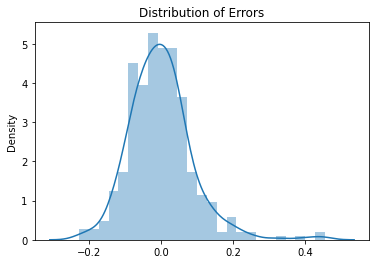

In [80]:
y_train_pred = lr.predict(X_train_sm)
res = y_train - y_train_pred
# Normality of error assumption
sns.distplot(res)
plt.title('Distribution of Errors')
plt.show()

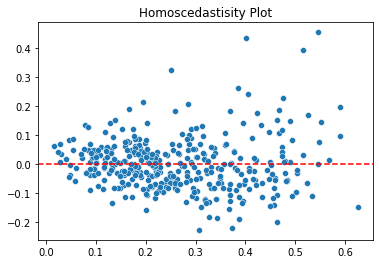

In [81]:
# Homoscedastisity
sns.scatterplot(y=res, x=y_train_pred)
plt.axhline(y=0, linestyle='--', color='r')
plt.title('Homoscedastisity Plot')
plt.show()

**Analysis on test set**

In [82]:
# scaling test data
housing_test[numerical] = scalar.transform(housing_test[numerical])
y_test = housing_test.pop('price')
X_test = housing_test

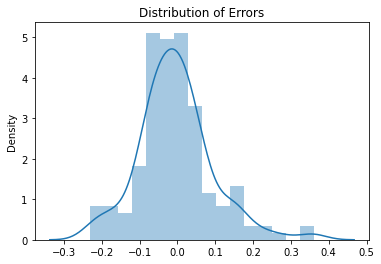

In [84]:
y_test_pred = lr.predict(sm.add_constant(X_test[columns]))
res = y_test - y_test_pred
# Normality of error assumption
sns.distplot(res)
plt.title('Distribution of Errors')
plt.show()

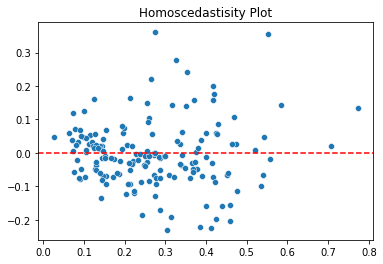

In [85]:
# Homoscedastisity
sns.scatterplot(y=res, x=y_test_pred)
plt.axhline(y=0, linestyle='--', color='r')
plt.title('Homoscedastisity Plot')
plt.show()

In [87]:
print('R2 score adjusted training {0} and test {1}'.format(lr.rsquared, r2_score(y_test, y_test_pred)))

R2 score adjusted training 0.6800930630265903 and test 0.6713505684480788


**Lets use RFE for automated feature elimination**

In [90]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10, 100)
rfe = rfe.fit(X_train, y_train)

In [94]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', False, 2),
 ('basement', False, 2),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 2),
 ('unfurnished', True, 1)]

In [95]:
columns_rfe = X_train.columns[rfe.support_]
columns_rfe

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'unfurnished'],
      dtype='object')

In [96]:
#creating model after rfe
lr_model = sm.OLS(y_train, sm.add_constant(X_train[columns_rfe])).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     75.12
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           8.84e-83
Time:                        18:04:48   Log-Likelihood:                 375.04
No. Observations:                 381   AIC:                            -728.1
Df Residuals:                     370   BIC:                            -684.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0217      0.019      1.134      0.258      -0.016       0.059
area                0.2416      0.030      7.999      0.000       0.182       0.301
bedrooms            0.0628      0.037      1.702      0.090      -0.010       0.135
bathrooms           0.2012      0.022      9.109      0.000       0.158       0.245
stories             0.0961      0.019      5.171      0.000       0.060       0.133
mainroad            0.0547      0.014      3.780      0.000       0.026       0.083
hotwaterheating     0.0877      0.022      4.014      0.000       0.045       0.131
airconditioning     0.0715      0.011      6.290      0.000       0.049       0.094
parking             0.0546      0.018      2.999      0.003       0.019       0.090
prefarea            0.0670      0.012      5.711      0.000       0.044       0.090
unfurnished        -0.0316      0.010     -3.061      0.002      -0.052      -0.011
==============================================================================
Omnibus:                       92.394   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              288.440
Skew:                           1.090   Prob(JB):                     2.32e-63
Kurtosis:                       6.663   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
vif_series(X_train[columns_rfe])

bedrooms           6.12
mainroad           5.60
area               4.63
stories            2.45
parking            2.10
airconditioning    1.74
bathrooms          1.64
prefarea           1.45
unfurnished        1.39
hotwaterheating    1.13
dtype: float64

In [98]:
# dropping bedrooms
columns_rfe = columns_rfe.drop('bedrooms')
lr_model = sm.OLS(y_train, sm.add_constant(X_train[columns_rfe])).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     82.72
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           3.93e-83
Time:                        18:06:34   Log-Likelihood:                 373.55
No. Observations:                 381   AIC:                            -727.1
Df Residuals:                     371   BIC:                            -687.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0427      0.015      2.920      0.004       0.014       0.072
area                0.2420      0.030      7.995      0.000       0.183       0.302
bathrooms           0.2096      0.022      9.710      0.000       0.167       0.252
stories             0.1073      0.017      6.157      0.000       0.073       0.142
mainroad            0.0527      0.014      3.646      0.000       0.024       0.081
hotwaterheating     0.0900      0.022      4.113      0.000       0.047       0.133
airconditioning     0.0715      0.011      6.267      0.000       0.049       0.094
parking             0.0573      0.018      3.153      0.002       0.022       0.093
prefarea            0.0679      0.012      5.780      0.000       0.045       0.091
unfurnished        -0.0328      0.010     -3.169      0.002      -0.053      -0.012
==============================================================================
Omnibus:                       98.478   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.889
Skew:                           1.148   Prob(JB):                     2.09e-70
Kurtosis:                       6.865   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""